Testing Mushi
==

Here's a notebook for playing with the `mushi` module

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
from mushi import History, SFS
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit

In [2]:
print(History.__doc__)
print(SFS.__doc__)

piecewise constant history of population size η and mutation rate μ
    
The SFS model described in the text
    


### demographic and mutation rate history

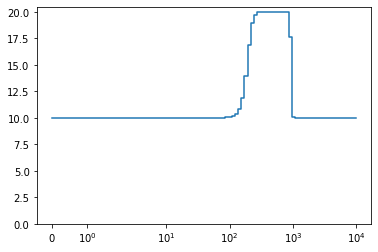

In [12]:
t = np.logspace(-1, 4, 100)
y = 2000 * np.ones(len(t) + 1)
z_flat = 10 * np.ones(len(t) + 1)
z_pulse = 10 * np.ones(len(t) + 1)
z_pulse[:-1] += 10 * (expit(.05 * (t - 200)) - expit(.05 * (t - 1000)))
history_TCC = History(t, y, z_pulse)
history_other = History(t, y, 95 * z_flat)

plt.step(history_TCC.t[:-1], history_TCC.z, where='post')
# plt.step(history_other.t[:-1], history_other.z , where='post')
plt.ylim([0, None])
plt.xscale('symlog')
plt.show()

### SFS

In [13]:
n = 200
sfs_TCC = SFS(n)
sfs_other = SFS(n)
sfs_TCC.simulate(history_TCC)
sfs_other.simulate(history_other)

In [14]:
history_initial = History(t, y, 10 * np.ones_like(history_TCC.z))
history_inferred = sfs_TCC.infer_μ(history_initial, λ_μ=1e-1, h=1e2)

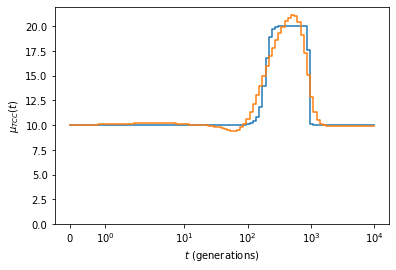

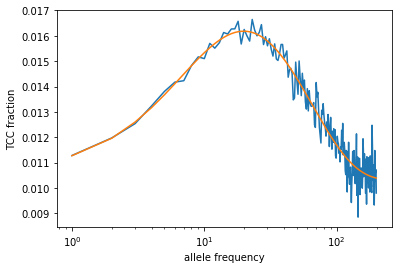

In [15]:
plt.step(history_TCC.t[:-1], history_TCC.z, where='post')
plt.step(history_inferred.t[:-1], history_inferred.z, where='post')
plt.ylim([0, 1.1 * history_TCC.z.max()])
plt.xscale('symlog')
plt.xlabel('$t$ (generations)')
plt.ylabel('$\mu_{TCC}(t)$')
plt.show()

sfs_total = sfs_TCC.sfs + sfs_other.sfs
plt.plot(range(1, n), sfs_TCC.sfs / sfs_total)
plt.plot(range(1, n), sfs_TCC.ξ(history_inferred) / ((sfs_TCC.ξ(history_inferred) + sfs_other.ξ(history_other))))
# plt.plot(range(1, n), sfs_TCC.ξ(history_TCC) / ((sfs_TCC.ξ(history_TCC) + sfs_other.ξ(history_other))))
plt.xscale('log')
plt.xlabel('allele frequency')
plt.ylabel('TCC fraction')
plt.show()

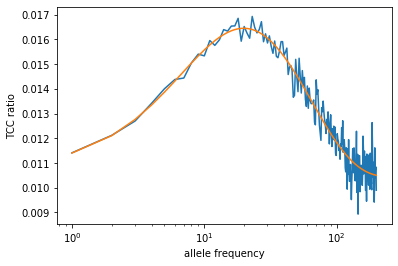

In [16]:
plt.plot(range(1, n), sfs_TCC.sfs / sfs_other.sfs)
plt.plot(range(1, n), sfs_TCC.ξ(history_inferred) / (sfs_other.ξ(history_other)))
# plt.plot(range(1, n), sfs_TCC.ξ(history_TCC) / ((sfs_TCC.ξ(history_TCC) + sfs_other.ξ(history_other))))
plt.xscale('log')
plt.xlabel('allele frequency')
plt.ylabel('TCC ratio')
plt.show()